[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/florpi/from-zero-to-generative/blob/main/1-zero-classifier.ipynb)

## 🛠️ Setting Up Our Toolbox

We'll be using the following packages throughout this notebook:

- `jax`: Our high-performance numerical computing library 
- `flax`: A neural network library designed for flexibility
- `optax`: Optimizers for JAX
- `numpy`: The swiss army knife of numerical computing
- `matplotlib`: For visualizing our creations

Let's install them all in one go:

In [2]:
#!pip install jax jaxlib flax torchvision torch

In [3]:
# as opposed to pytorch, jax handles device placement automatically
# Now let's check wehther you are actually using a gpu, if so, the output should be a cuda id, otherwise you are using a cpu
import jax
print(jax.devices())

[cuda(id=0)]


## 🔢 Training a Digit Classifier: Decoding Doctor's Handwriting

Ever squinted at a prescription, trying to decipher if that's a 5 or a 6? You're not alone! Doctors' notoriously illegible handwriting has been the subject of jokes and genuine concern for years. Our task is to create a handwritten digit classifier using machine learning. 



## 🧱 Building Block #1: The Data

Every great AI needs a solid foundation, and in machine learning, that foundation is data. Machine Learning has been largely shaped by benchmarks - standardized datasets that serve as proving grounds for new algorithms. These datasets, along with their associated metrics, have driven the field forward by providing common challenges for researchers to tackle. Today, we'll be working with the MNIST dataset - the "Hello World" of machine learning. 

> 🎓 **MNIST History**: MNIST (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that has been used for training and testing in the field of machine learning since its creation in 1998. It's often called the "Drosophila of machine learning" - just as the fruit fly is a model organism in biology!

### 🎨 Other Exciting Datasets

Once you've mastered MNIST, here are some other fun datasets you might want to explore:

- 😀 [FER2013](https://pytorch.org/vision/main/generated/torchvision.datasets.FER2013.html): For those interested in facial expressions
- ✍️ [KMNIST](https://pytorch.org/vision/main/generated/torchvision.datasets.KMNIST.html): Beautiful cursive Japanese characters
- 🍔 [Food101](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html): For the foodies out there
- 🦁 [INaturalist](https://pytorch.org/vision/main/generated/torchvision.datasets.INaturalist.html): A treasure trove for nature lovers

### 🚀 Ready for the Big Leagues?

If you're itching to apply generative models to scientific problems, check out the CAMELS suite of astrophysical simulations. 

---

Ready to start building with our MNIST building blocks? Let's dive in! 🏗️💻

In [4]:
import torchvision
import torchvision.transforms as transforms
import numpy as np
import jax.numpy as jnp

# These transformations are applied to the data as it is loaded, do not worry too much about them, but I leave some explanations on why they are there for you to understand in case you are curious / confused
transform = transforms.Compose(
    (
        transforms.ToTensor(), # This will transform the original data format of the images into pytorch tensors, so that we can use the Normalize transform on them 
        transforms.Normalize((0.5,), (0.5,)), # The images are originally scaled between 0 and 1, but generative models would usually standarize them to have 0 mean and 1 std
        transforms.Lambda(lambda x: np.transpose(np.array(x), (1,2,0))), # we will convert pytorch tensors into jax obejects. An odd distinction between jax and pytorch is how they assume
        # image data is loaded. For pytorch an image has shape (n_channels, n_pixels, n_pixels) whereas for jax it should be (n_pixels, n_pixels, n_channels), hence the transpose...
    )
)
# Now we will create a dataset that can download and obtain the data we want
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)


In [5]:
# this is how we can get one example from our dataset
image, target = train_dataset[0]

In [6]:
# the label of the example
target

5

In [7]:
# the shape of the example. This is an image with one channel (grayscale) and 28 pixels

image.shape

(28, 28, 1)

Text(0.5, 1.0, 'Target = 5')

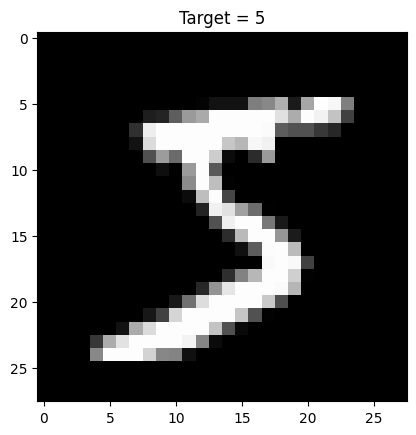

In [8]:
# and let's have a look at the image using matplotlib, feel free to visualize others by changing the index here:
# #TODO always check your data loader and make sure the labels seem sensible by visual inspection
index = 0
image, target = train_dataset[index]

import matplotlib.pyplot as plt
plt.imshow(image[:,:,0], cmap='gray')
plt.title(f'Target = {target}')

In [9]:
# but we want to get batches (groups) of examples from the training set, for that we will need a data loader that randomly loads batches of examples:
from torch.utils.data import DataLoader
batch_size = 64 #128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

train_loader = iter(train_dataloader)

In [10]:
# Now when we call batch, we get a fresh batch of data and labels
x_batch, y_batch = next(train_loader)

In [11]:
x_batch.shape

torch.Size([64, 28, 28, 1])

## 🏗️ Building Block #2: The Model Architecture

Now that we have our data foundation, it's time to design the structure of our model. For our first venture into the world of neural architectures, we're going to keep things elegantly simple. We'll be constructing a Fully Connected Network, also known as a Dense Network or Multi-Layer Perceptron (MLP).



In [12]:
#TODO : Fill in architecture
import flax.linen as nn

class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x.reshape((x.shape[0], -1))  # Flatten the input
        # linear transformation
        x = nn.Dense(features=512)(x)
        # non-linear activation function
        x = nn.silu(x)
        x = nn.Dense(features=256)(x)
        x = nn.silu(x)
        x = nn.Dense(features=10)(x)
        return x

model = MLP()

### 🎲 Initializing the Parameters

Our neural network now needs its parameters (weights and biases) initialized properly. This is crucial because:

- Good initialization can help our model learn faster
- It can prevent issues like vanishing or exploding gradients
- Different initializations can lead to different final performances

### 🔮 JAX's Magic: Shape Inference and Initialization

JAX comes with some nifty features that make building and initializing networks easy peasy:

1. **Shape Inference**: 
   - JAX can automatically figure out the shapes of your layers
   - You often only need to specify the output size of each layer

2. **Easy Initialization**:
   - JAX provides initialization functions in `jax.nn.initializers`
   - These functions create initializer closures that JAX uses to set initial parameter values

All we need is an example input, it doesn't matter its content, only its shape

In [13]:

example_input = jnp.ones((1,28,28,1))
params = model.init(jax.random.PRNGKey(0), example_input)  # Example input for shape inference


In [14]:
# let's look at params, it should be a dictionary containing the parameters' names and values
params

{'params': {'Dense_0': {'kernel': Array([[-0.03913071,  0.05444214,  0.04740295, ...,  0.06523018,
            0.01198721,  0.08043633],
          [ 0.01668966, -0.00612889,  0.00993335, ..., -0.02016362,
            0.04787786,  0.05100662],
          [-0.04086368,  0.05011395, -0.00382218, ...,  0.03551806,
            0.00043432,  0.01461799],
          ...,
          [ 0.00547553, -0.02139576,  0.03528887, ..., -0.06179288,
            0.02263864, -0.02301445],
          [ 0.03864831, -0.00599695,  0.00455287, ...,  0.00773665,
           -0.04161146, -0.03113718],
          [-0.08020224, -0.06572444, -0.06583147, ..., -0.04730775,
           -0.01103787,  0.02308792]], dtype=float32),
   'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [15]:
# Let's now see how the neural network output looks like:
# the way models are called are through the apply function, that takes the parameters as an argument, and the inputs to the neural network. In this case, our images
y = model.apply(params, x_batch)

In [16]:
# so it will output the probability of each class
y.shape

(64, 10)

In [17]:
# You can have a look at the shape of the parameters of the first layer in the neural network, the Dense_0 layer
params['params']['Dense_0']['kernel'].shape

(784, 512)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 512.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-0.5       , -0.44999999, -0.40000001, -0.34999999, -0.30000001,
        -0.25      , -0.2       , -0.15000001, -0.1       , -0.05      ,
         0.        ,  0.05      ,  0.1       ,  0.15000001,  0.2       ,
         0.25      ,  0.30000001,  0.34999999,  0.40000001,  0.44999999,
         0.5       ]),
 <BarContainer object of 20 artists>)

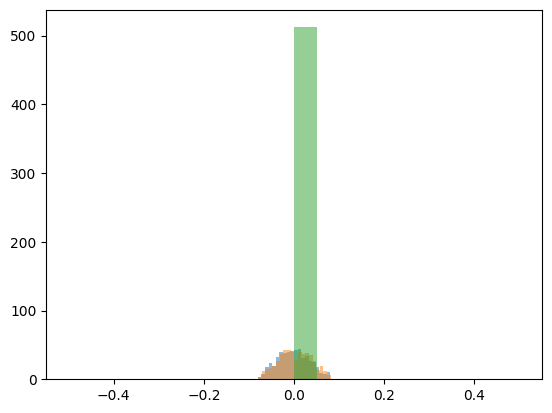

In [18]:
# let's look at the histograms of some of parameter values, that will show us how they were initialized
# so it looks like the biases were initialized to 0, but not the kernels , that seem to be Gaussian distributed
plt.hist(params['params']['Dense_0']['kernel'][0], bins=20, alpha=0.5,)
plt.hist(params['params']['Dense_0']['kernel'][10], bins=20, alpha=0.5,)
plt.hist(params['params']['Dense_0']['bias'], bins=20, alpha=0.5,)

## 📐 Building Block #3: The Loss Function

Now that we've laid out our neural network's structure, we need a way to measure how well it's performing.

### 🎯 Cross-Entropy Loss

For our digit classification task, we'll use the cross-entropy loss. This is the go-to loss function for multi-class classification problems like ours.

$$ L = -\sum_{i=1}^{C} y_i \log(\hat{y}_i) $$

Where:
- $L$ is the loss
- $C$ is the number of classes (in our case, 10 digits)
- $y_i$ is the true probability of class $i$ (1 for the correct digit, 0 for others)
- $\hat{y}_i$ is the predicted probability of class $i$

In practice, $y$ is usually a one-hot encoded vector, and $\hat{y}$ comes from applying softmax to our model's output.



In [19]:
#TODO: Fill in loss function
def cross_entropy_loss(logits, labels):
    one_hot = jax.nn.one_hot(labels, num_classes=10)
    return -jnp.mean(jnp.sum(one_hot * jax.nn.log_softmax(logits), axis=-1))


## 🔧 Building Block #4: The Optimizer

Now we need to be able to fine-tune the parameters of our neural network such that we can minimize the loss function. An optimizer is an algorithm that adjusts the parameters of our model to minimize the loss. 

### 💡 Popular Optimizers

While there are many optimizers out there, we'll focus on two common choices:

1. **Stochastic Gradient Descent (SGD)**: The classic choice. Simple but effective.
2. **Adam**: An adaptive method that often converges faster. It's like SGD with superpowers!



In [20]:

import optax

learning_rate = 1.e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

In [21]:
# The training step (run with and without jax.jit to see the difference in speed)
# It computes the loss, and uses its gradients to update the parameters

@jax.jit
def train_step(params, opt_state, batch):
    images, labels = batch
    def loss_fn(params):
        logits = model.apply(params, images)
        loss = cross_entropy_loss(logits, labels)
        return loss
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss



In [22]:
from tqdm import tqdm

# Training loop in terms of steps
num_steps = 1_000


train_loss = []

with tqdm(total=num_steps, desc='Training', unit='step') as pbar:
    for step in range(num_steps):
        try:
            images, labels = next(train_loader)
        except StopIteration:
            # Once the dataset is empty, we will reinitialize the data loader to keep training
            train_loader = iter(train_dataloader)
            images, labels = next(train_loader)
        images, labels = jnp.array(images), jnp.array(labels)

        params, opt_state, loss = train_step(params, opt_state, (images, labels))
        train_loss.append(loss)
        pbar.set_postfix(loss=loss)
        pbar.update(1)


Training:   0%|          | 0/1000 [00:00<?, ?step/s]

Training: 100%|██████████| 1000/1000 [00:19<00:00, 51.24step/s, loss=0.11832994]


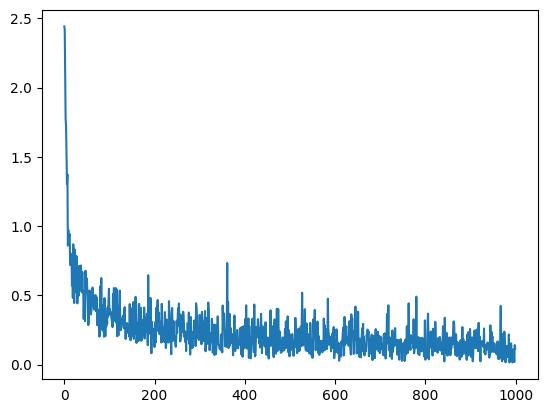

In [23]:
plt.plot(train_loss)

Now we will use an independent test set to asses how good our model truly is

In [24]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)


In [25]:
# Final evaluation on the test set
# TODO: compute accuracy
test_accuracy = 0
num_batches = 0
for batch in test_loader:
    images, labels = batch
    images, labels = jnp.array(images), jnp.array(labels)
    logits = model.apply(params, images)
    probability = jax.nn.softmax(logits)
    predictions = jnp.argmax(logits, axis=-1)
    test_accuracy += jnp.mean(predictions == labels)
    num_batches += 1
test_accuracy /= num_batches
print(f'Final Test Accuracy: {test_accuracy * 100:.2f}%')

Final Test Accuracy: 96.62%


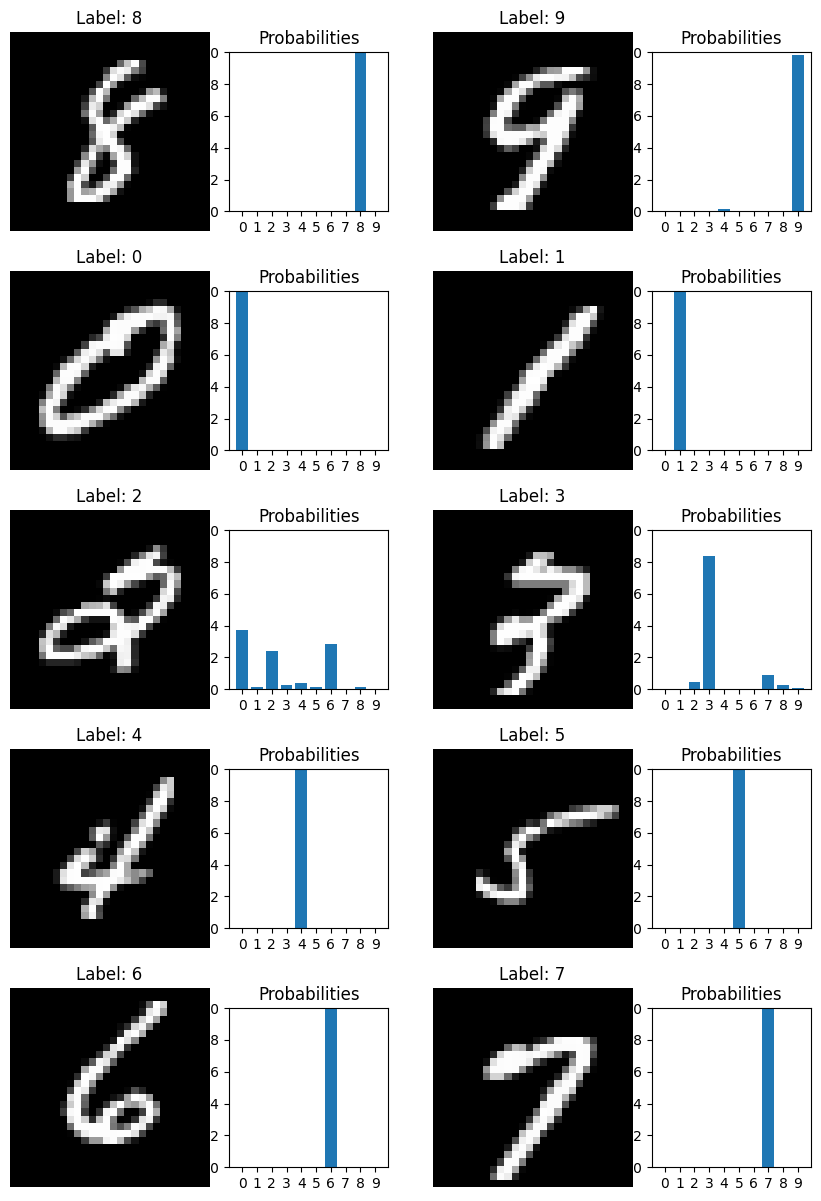

In [26]:
# let's look at the output probabilities
fig, axs = plt.subplots(5, 2, figsize=(10, 15))

for i in range(10):
    img = images[i][:,:,0]
    label = labels[i]
    prob = probability[i]
    ax = axs[i // 2, i % 2]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Label: {label}')
    
    # Create a new axis for the probability bar plot
    ax_prob = ax.inset_axes([1.1, 0.1, 0.8, 0.8])  # Adjust position and size as needed
    ax_prob.bar(range(10), prob)
    ax_prob.set_xticks(range(10))
    ax_prob.set_ylim(0, 1)
    ax_prob.set_title('Probabilities')

#plt.tight_layout()
plt.show()

Extra question: how would you assess whether the probability outputs themselves are meaningful (i.e., are well callibrated?) 